In [1]:
import rsatoolbox as rsa
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

plt.close('all')
plt.style.use('default')

# Add the parent directory to sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_path not in sys.path:
    sys.path.append(project_path)

import globals as gl

fontsize = 12


Base directory found: /Volumes/diedrichsen_data$/data/Chord_exp/ExtFlexChord


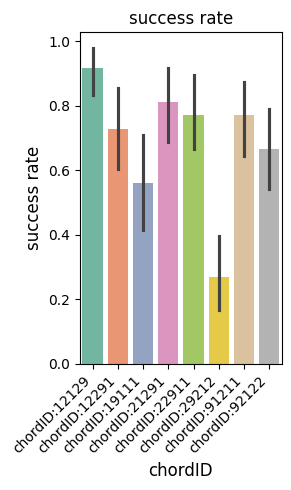

In [46]:
import pandas as pd
import seaborn as sns

experiment = 'efc4'
sn = 100
day = 1

data = pd.read_csv(os.path.join(gl.baseDir, experiment, gl.behavDir, f'day{day}',f'subj{sn}', 'single_trial.tsv'), sep='\t')
data['chordID'] = 'chordID:' + data['chordID'].astype(str)
data['BN'] = data['BN'].astype(int)

fig, axs = plt.subplots(figsize=(3, 5),)

sns.barplot(data, ax=axs, x='chordID', y='trialPoint' , legend=None, order=sorted(data['chordID'].unique()), palette=gl.colour_mapping['glm1'].values())

axs.set_title('success rate', fontsize=fontsize)
axs.set_xlabel('chordID', fontsize=fontsize)
axs.set_ylabel('success rate', fontsize=fontsize)
axs.set_xticklabels(axs.get_xticklabels(), rotation=45, ha='right')
    
fig.tight_layout()

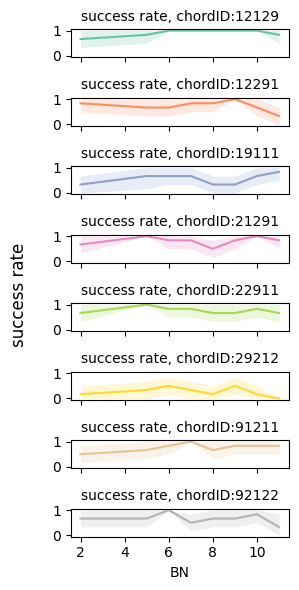

In [47]:
import pandas as pd
import seaborn as sns

experiment = 'efc4'
sn = 100
day = 1

data = pd.read_csv(os.path.join(gl.baseDir, experiment, gl.behavDir, f'day{day}',f'subj{sn}', 'single_trial.tsv'), sep='\t')
data['chordID'] = data['chordID'].astype(str)
data['chordID'] = 'chordID:' + data['chordID'].astype(str)
data['BN'] = data['BN'].astype(int)

fig, axs = plt.subplots(8, figsize=(3, 6), sharex=True, sharey=True)

for ch, chordID in enumerate(sorted(data['chordID'].unique())):
    sns.lineplot(data[data['chordID']==chordID], ax=axs[ch], x='BN', y='trialPoint' ,  legend=None,err_kws={'linewidth': 0}, color=
        list(gl.colour_mapping['glm1'].values())[ch])
    axs[ch].set_title(f'success rate, {chordID}', fontsize=10)
    
    axs[ch].set_ylabel('')
    
fig.supylabel('success rate', fontsize=fontsize)
fig.tight_layout()

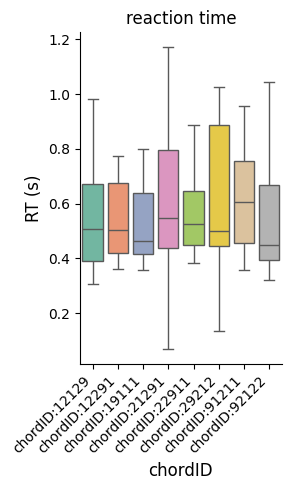

In [48]:
experiment = 'efc4'
sn = 100
day = 1

data = pd.read_csv(os.path.join(gl.baseDir, experiment, gl.behavDir, f'day{day}',f'subj{sn}', 'single_trial.tsv'), sep='\t')
data['chordID'] = data['chordID'].astype(str)
data['chordID'] = 'chordID:' + data['chordID'].astype(str)
data['BN'] = data['BN'].astype(int)

fig, axs = plt.subplots(figsize=(3, 5))

sns.boxplot(data, ax=axs, x='chordID', y='RT' , showfliers=False, order=sorted(data['chordID'].unique()),  palette=gl.colour_mapping['glm1'].values())

axs.legend(frameon=False, loc='lower right', ncol=1, fontsize=fontsize)

axs.spines[['right', 'top']].set_visible(False)

axs.set_title('reaction time', fontsize=fontsize)
axs.set_xlabel('chordID', fontsize=fontsize)
axs.set_ylabel('RT (s)', fontsize=fontsize)
axs.set_xticklabels(axs.get_xticklabels(), rotation=45, ha='right')

fig.tight_layout()

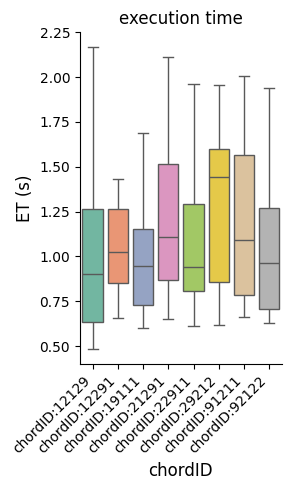

In [49]:
experiment = 'efc4'
sn = 100
day = 1

data = pd.read_csv(os.path.join(gl.baseDir, experiment, gl.behavDir, f'day{day}',f'subj{sn}', 'single_trial.tsv'), sep='\t')
data['chordID'] = data['chordID'].astype(str)
data['chordID'] = 'chordID:' + data['chordID'].astype(str)
data['BN'] = data['BN'].astype(int)

fig, axs = plt.subplots(figsize=(3, 5))

sns.boxplot(data, ax=axs, x='chordID', y='ET' , showfliers=False, order=sorted(data['chordID'].unique()),  palette=gl.colour_mapping['glm1'].values())

axs.legend(frameon=False, loc='lower right', ncol=1, fontsize=fontsize)

axs.spines[['right', 'top']].set_visible(False)

axs.set_title('execution time', fontsize=fontsize)
axs.set_xlabel('chordID', fontsize=fontsize)
axs.set_ylabel('ET (s)', fontsize=fontsize)
axs.set_xticklabels(axs.get_xticklabels(), rotation=45, ha='right')

fig.tight_layout()

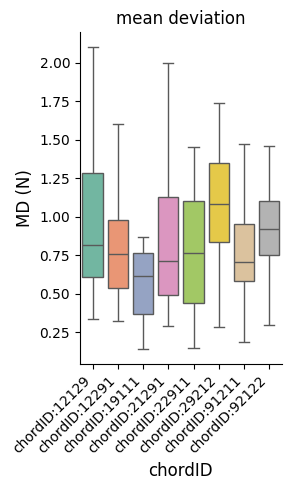

In [50]:
experiment = 'efc4'
sn = 100
day = 1

data = pd.read_csv(os.path.join(gl.baseDir, experiment, gl.behavDir, f'day{day}',f'subj{sn}', 'single_trial.tsv'), sep='\t')
data['chordID'] = data['chordID'].astype(str)
data['chordID'] = 'chordID:' + data['chordID'].astype(str)
data['BN'] = data['BN'].astype(int)

fig, axs = plt.subplots(figsize=(3, 5))

sns.boxplot(data, ax=axs, x='chordID', y='MD' , showfliers=False, order=sorted(data['chordID'].unique()),  palette=gl.colour_mapping['glm1'].values())

axs.legend(frameon=False, loc='lower right', ncol=1, fontsize=fontsize)

axs.spines[['right', 'top']].set_visible(False)

axs.set_title('mean deviation', fontsize=fontsize)
axs.set_xlabel('chordID', fontsize=fontsize)
axs.set_ylabel('MD (N)', fontsize=fontsize)
axs.set_xticklabels(axs.get_xticklabels(), rotation=45, ha='right')

fig.tight_layout()

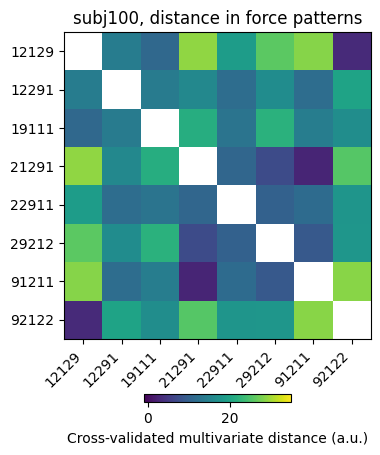

In [51]:
experiment = 'efc4'

vmin, vmax = -1, 35
participant_id='subj100'

fig, axs = plt.subplots()

rdms = rsa.rdm.load_rdm(os.path.join(gl.baseDir, experiment, gl.rdmDir, 'day1', participant_id, f'force.hdf5'))

cax = rsa.vis.show_rdm_panel(
                rdms, axs, rdm_descriptor='roi', cmap='viridis', vmin=vmin, vmax=vmax
            )

axs.set_xticks(np.arange(len(rdms.pattern_descriptors['conds'])))
axs.set_xticklabels(rdms.pattern_descriptors['conds'], rotation=45, ha='right')
axs.set_yticks(axs.get_xticks())
axs.set_yticklabels(rdms.pattern_descriptors['conds'])
axs.set_title(f'{participant_id}, distance in force patterns')

cbar = fig.colorbar(cax, ax=axs, orientation='horizontal', fraction=.02)
cbar.set_label('Cross-validated multivariate distance (a.u.)')


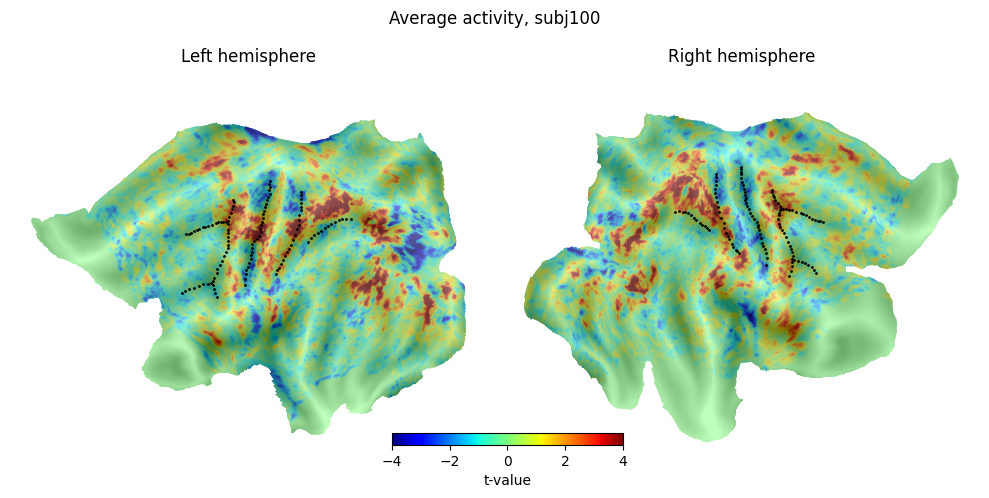

In [3]:
import nibabel as nb
import nitools
from matplotlib.cm import ScalarMappable

sys.path.append('/Users/mnlmrc/Documents/GitHub')
sys.path.append('/home/ROBARTS/memanue5/Documents/GitHub')

import surfAnalysisPy as surf

experiment = 'efc4'
sn = 100
glm = 1
day = 1
Hem = ['L', 'R']

vmin, vmax = -4, 4

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for ax, H in zip(axs, Hem):
    
    D = nb.load(os.path.join(gl.baseDir, experiment, gl.wbDir, f'subj{sn}', f'glm{glm}.day{day}.spmT.{H}.func.gii'))
    darray = nitools.get_gifti_data_matrix(D)
    
    plt.sca(ax)
    surf.plot.plotmap(darray.mean(axis=1), f'fs32k_{H}',
                      underlay=None,
                      borders=gl.borders[H],
                      cscale=[vmin, vmax],
                      cmap='jet',
                      underscale=[-1.5, 1],
                      alpha=.5,
                      new_figure=False,
                      colorbar=False,
                      # frame=[xlim[0], xlim[1], ylim[0], ylim[1]]
                      )

# make colorbar
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='jet')
cbar = fig.colorbar(sm, ax=[axs[0], axs[1]], orientation='horizontal', fraction=0.03)
cbar.set_label('t-value')

axs[0].set_title('Left hemisphere')
axs[1].set_title('Right hemisphere')

fig.suptitle(f'Average activity, subj{sn}')
fig.tight_layout()

Text(0.5, 1.0, 'Right hemisphere')

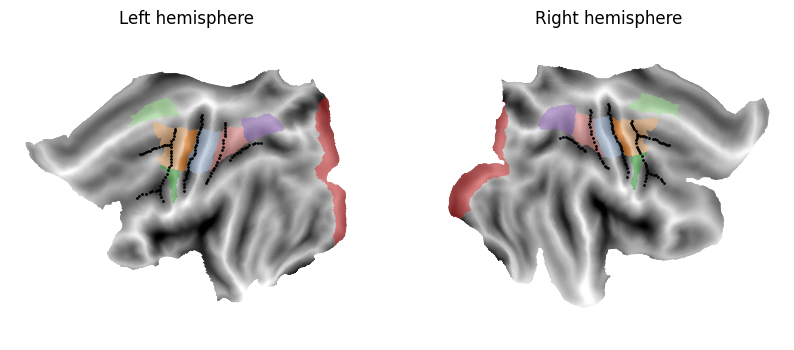

In [27]:
import matplotlib.colors as mcolors
import matplotlib.colorbar as cbar

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

atlas = 'ROI'
Hem = ['L', 'R']

for ax, H in zip(axs, Hem):
    
    D = nb.load(os.path.join(gl.atlasDir, f'{atlas}.32k.{H}.label.gii'))
    darray = nitools.get_gifti_data_matrix(D)
    
    plt.sca(ax)
    surf.plot.plotmap(darray, f'fs32k_{H}',
                      underlay=None,
                      borders=gl.borders[H],
                      cmap='tab20',
                      underscale=[-1.5, 1],
                      alpha=.5,
                      new_figure=False,
                      colorbar=False,
                      )
    
axs[0].set_title('Left hemisphere')
axs[1].set_title('Right hemisphere')


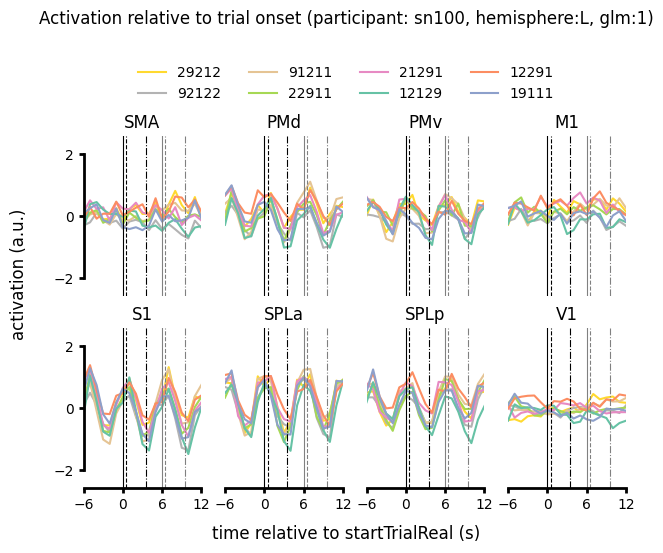

In [97]:
import scipy

experiment = 'efc4'
Hem = 'L'
roi = ['SMA', 'PMd', 'PMv', 'M1', 'S1', 'SPLa', 'SPLp', 'V1']
r = 0
glm = 1
day = 1
sn=100

mat = scipy.io.loadmat(os.path.join(gl.baseDir, experiment, gl.roiDir, f'day{day}', f'subj{sn}', f'hrf_glm{glm}.mat'))
T = mat['T'][0, 0]
T_fields = T.dtype.names
T_dict = {field: T[field] for field in T_fields}

tAx = np.linspace(-6, 12, 19)

fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(7, 5.5))
for i in range(2):
    for j in range(4):

        for ch in gl.chordID:
            y_adj = np.nanmean(T_dict['y_adj'][((T_dict['name'] == roi[r]) & (T_dict['chordID'] == ch) & (T_dict['hem'] == Hem)).flatten()], axis=0)
            # y_hat = np.nanmean(T_dict['y_hat'][((T_dict['name'] == roi[r]) & (T_dict['chordID'] == ch) &  (T_dict['hem'] == Hem)).flatten()], axis=0)

            axs[i, j].plot(tAx, y_adj, color=gl.colour_mapping[f'glm{glm}'][f'chordID:{ch}'], label=ch, ls='-')
            # axs[i, j].plot(tAx, y_hat, color=gl.colour_mapping[f'glm{glm}'][f'chordID:{ch}'], label='go hat', ls='--')

        axs[i, j].axvline(0, color='k', ls='-', lw=.8)
        axs[i, j].axvline(.5, color='k', ls='--', lw=.8)
        axs[i, j].axvline(3.5, color='k', ls='-.', lw=.8)
        axs[i, j].axvline(6, color='grey', ls='-', lw=.8)
        axs[i, j].axvline(6.5, color='grey', ls='--', lw=.8)
        axs[i, j].axvline(9.5, color='grey', ls='-.', lw=.8)
        axs[i, j].set_title(roi[r])
        axs[i, j].set_xlim([-6, 12])
        axs[i, j].set_xticks([ -6, 0, 6, 12])

        # Remove unnecessary spines
        axs[i, j].spines['top'].set_visible(False)
        axs[i, j].spines['right'].set_visible(False)

        # Hide left and bottom spines based on row/column
        if i == 0:
            axs[i, j].spines['bottom'].set_visible(False)  # First row, hide bottom spine
        if j > 0:
            axs[i, j].spines['left'].set_visible(False)  # Hide left spines except first column

        # Hide ticks for non-left columns and first row
        if j > 0:
            axs[i, j].tick_params(axis='y', left=False)
        if i == 0:
            axs[i, j].tick_params(axis='x', bottom=False)

        r += 1

# Ensure left spines and ticks are visible for the first column
for i in range(2):
    axs[i, 0].spines['left'].set_visible(True)  # Show left spine for first column
    axs[i, 0].spines['left'].set_linewidth(2)  # Set left spine width for first column
    axs[i, 0].set_ylim([-2.6, 2.6])
    axs[i, 0].spines['left'].set_bounds([-2, 2])
    axs[i, 0].tick_params(axis='y', width=2)  # Show y-axis ticks for the first column

# Ensure bottom spines and ticks are visible for the second row
for j in range(4):
    axs[1, j].spines['bottom'].set_visible(True)  # Show bottom spine for second row
    axs[1, j].spines['bottom'].set_linewidth(2)  # Set bottom spine width for second row
    axs[1, j].spines['bottom'].set_bounds([-6, 12])
    axs[1, j].tick_params(axis='x', width=2)  # Show x-axis ticks for second row

# Legend and labels
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, .9), frameon=False)
fig.supylabel('activation (a.u.)')
fig.supxlabel('time relative to startTrialReal (s)')
fig.suptitle(f'Activation relative to trial onset (participant: sn{sn}, hemisphere:{Hem}, glm:{glm})')

fig.subplots_adjust(top=0.75)


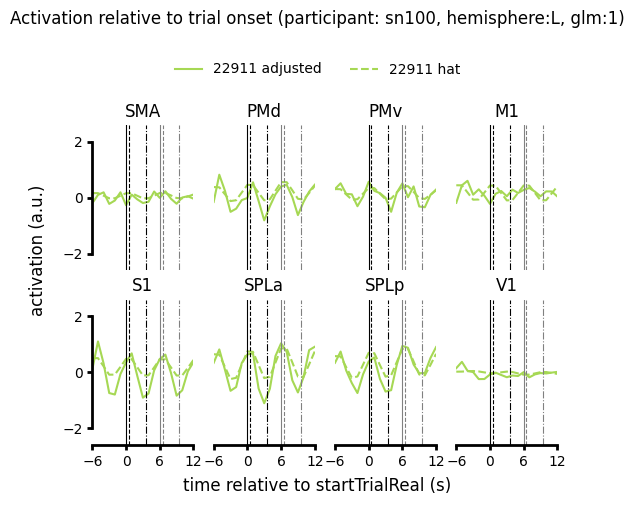

In [93]:
experiment = 'efc4'
Hem = 'L'
roi = ['SMA', 'PMd', 'PMv', 'M1', 'S1', 'SPLa', 'SPLp', 'V1']
r = 0
glm = 1
day = 1
sn=100

mat = scipy.io.loadmat(os.path.join(gl.baseDir, experiment, gl.roiDir, f'day{day}', f'subj{sn}', f'hrf_glm{glm}.mat'))
T = mat['T'][0, 0]
T_fields = T.dtype.names
T_dict = {field: T[field] for field in T_fields}

chordID = 22911 # [29212, 92122, 91211, 22911, 21291, 12129, 12291, 19111]

tAx = np.linspace(-6, 12, 19)

fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(6, 5))
for i in range(2):
    for j in range(4):

        y_adj = np.nanmean(T_dict['y_adj'][((T_dict['name'] == roi[r]) & (T_dict['chordID'] == chordID) & (T_dict['hem'] == Hem)).flatten()], axis=0)
        y_hat = np.nanmean(T_dict['y_hat'][((T_dict['name'] == roi[r]) & (T_dict['chordID'] == chordID) &  (T_dict['hem'] == Hem)).flatten()], axis=0)

        axs[i, j].plot(tAx, y_adj, color=gl.colour_mapping[f'glm{glm}'][f'chordID:{chordID}'], label=f'{chordID} adjusted', ls='-')
        axs[i, j].plot(tAx, y_hat, color=gl.colour_mapping[f'glm{glm}'][f'chordID:{chordID}'], label=f'{chordID} hat', ls='--')

        axs[i, j].axvline(0, color='k', ls='-', lw=.8)
        axs[i, j].axvline(.5, color='k', ls='--', lw=.8)
        axs[i, j].axvline(3.5, color='k', ls='-.', lw=.8)
        axs[i, j].axvline(6, color='grey', ls='-', lw=.8)
        axs[i, j].axvline(6.5, color='grey', ls='--', lw=.8)
        axs[i, j].axvline(9.5, color='grey', ls='-.', lw=.8)
        axs[i, j].set_title(roi[r])
        axs[i, j].set_xlim([-6, 12])
        axs[i, j].set_xticks([ -6, 0, 6, 12])

        # Remove unnecessary spines
        axs[i, j].spines['top'].set_visible(False)
        axs[i, j].spines['right'].set_visible(False)

        # Hide left and bottom spines based on row/column
        if i == 0:
            axs[i, j].spines['bottom'].set_visible(False)  # First row, hide bottom spine
        if j > 0:
            axs[i, j].spines['left'].set_visible(False)  # Hide left spines except first column

        # Hide ticks for non-left columns and first row
        if j > 0:
            axs[i, j].tick_params(axis='y', left=False)
        if i == 0:
            axs[i, j].tick_params(axis='x', bottom=False)

        r += 1

# Ensure left spines and ticks are visible for the first column
for i in range(2):
    axs[i, 0].spines['left'].set_visible(True)  # Show left spine for first column
    axs[i, 0].spines['left'].set_linewidth(2)  # Set left spine width for first column
    axs[i, 0].set_ylim([-2.6, 2.6])
    axs[i, 0].spines['left'].set_bounds([-2, 2])
    axs[i, 0].tick_params(axis='y', width=2)  # Show y-axis ticks for the first column

# Ensure bottom spines and ticks are visible for the second row
for j in range(4):
    axs[1, j].spines['bottom'].set_visible(True)  # Show bottom spine for second row
    axs[1, j].spines['bottom'].set_linewidth(2)  # Set bottom spine width for second row
    axs[1, j].spines['bottom'].set_bounds([-6, 12])
    axs[1, j].tick_params(axis='x', width=2)  # Show x-axis ticks for second row

# Legend and labels
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, .9), frameon=False)
fig.supylabel('activation (a.u.)')
fig.supxlabel('time relative to startTrialReal (s)')
fig.suptitle(f'Activation relative to trial onset (participant: sn{sn}, hemisphere:{Hem}, glm:{glm})')

fig.subplots_adjust(top=0.75)


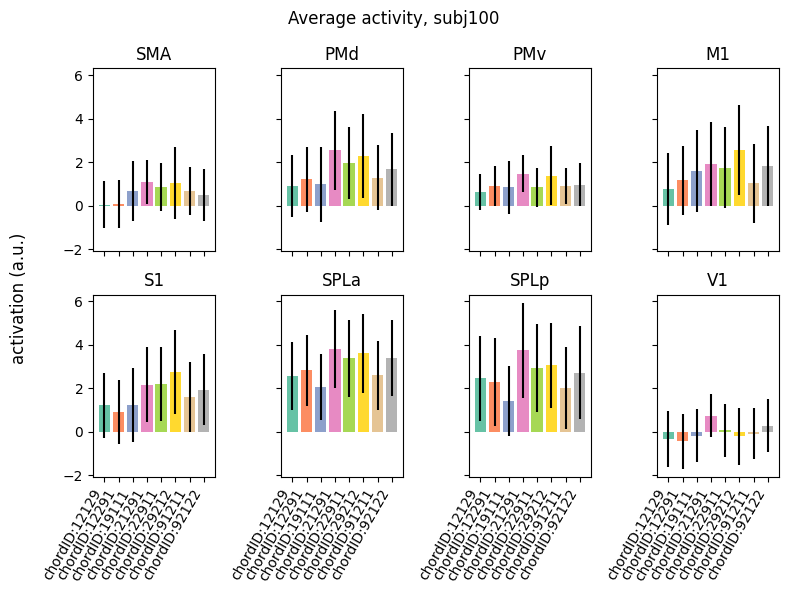

In [66]:
import pandas as pd

experiment = 'efc4'
sn = 100
glm = 1
day = 1
Hem = 'L'
rois = ['SMA', 'PMd', 'PMv', 'M1', 'S1', 'SPLa', 'SPLp', 'V1']

reginfo = pd.read_csv(os.path.join(gl.baseDir, experiment, f'{gl.glmDir}{glm}', f'day{day}',f'subj{sn}',
                                       f'reginfo.tsv'), sep="\t")
regressors = reginfo['name'].unique()

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(8, 6), sharey=True, sharex=True)

con_avg = np.zeros((len(rois), len(regressors)))

for r, roi in enumerate(rois):
    
    row = r // 4  
    col = r % 4
    
    con = np.load(os.path.join(gl.baseDir, experiment, f'{gl.glmDir}{glm}', f'day{day}', f'subj{sn}', f'ROI.{Hem}.{roi}.con.npy'))
    
    for regr, regressor in enumerate(regressors):
        con_tmp = con[reginfo.name.str.replace(" ", "").unique() == regressor].mean()

        con_avg[r, regr] = con_tmp

        con_tmp_err = con[reginfo.name.str.replace(" ", "").unique() == regressor].std() / np.sqrt(len(con))
        axs[row, col].bar(regressor, con_tmp, color=gl.colour_mapping[f'glm{glm}'][regressor], label=regressor, yerr=con_tmp_err)
        
    axs[row, col].set_title(roi)
    # axs[row, col].tick_params(axis='x', rotation=45)
    axs[row, col].set_xticklabels(regressors, ha='right', rotation=60)
    
fig.supylabel('activation (a.u.)')
fig.suptitle(f'Average activity, subj{sn}')
fig.tight_layout()

Text(0.5, 1.0, 'Similarity in activation profiles across chords')

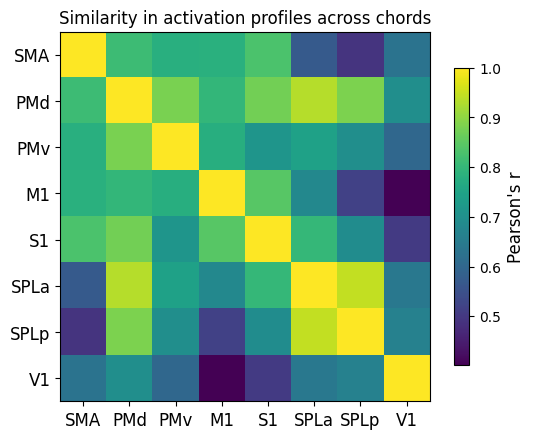

In [67]:
corr = np.corrcoef(con_avg)

fig, axs = plt.subplots()

cax = axs.imshow(corr)

axs.set_xticks(np.linspace(0, len(rois) - 1, len(rois)))
axs.set_xticklabels(rois, fontsize=12)

axs.set_yticks(np.linspace(0, len(rois) - 1, len(rois)))
axs.set_yticklabels(rois, fontsize=12)

cbar = fig.colorbar(cax, ax=axs, orientation='vertical', fraction=.03)
cbar.set_label("Pearson's r", fontsize=12)

axs.set_title('Similarity in activation profiles across chords', fontsize=12)

plotting...glm1.L.SMA.hdf5
plotting...glm1.L.PMd.hdf5
plotting...glm1.L.PMv.hdf5
plotting...glm1.L.M1.hdf5
plotting...glm1.L.S1.hdf5
plotting...glm1.L.SPLa.hdf5
plotting...glm1.L.SPLp.hdf5
plotting...glm1.L.V1.hdf5


Text(0.5, 0.98, 'participant:subj100, hemisphere:L')

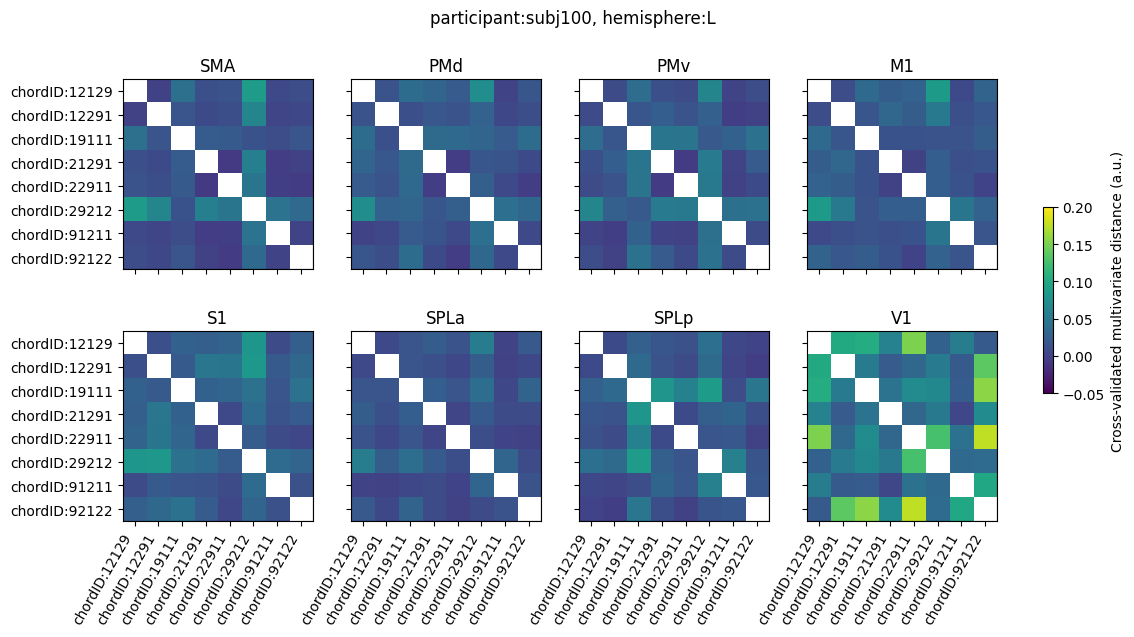

In [68]:
roi = ['SMA', 'PMd', 'PMv', 'M1', 'S1', 'SPLa', 'SPLp', 'V1']

experiment = 'efc4'

Hem = 'L'
r = 0
glm = 1
vmin, vmax = -.05, .2
participant_id='subj100'
fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(12, 6))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        print(f'plotting...glm{glm}.{Hem}.{roi[r]}.hdf5')
        rdms = rsa.rdm.load_rdm(os.path.join(gl.baseDir, experiment, gl.rdmDir, 'day1',participant_id,f'glm{glm}.{Hem}.{roi[r]}.hdf5'))

        cax = rsa.vis.show_rdm_panel(
                rdms, axs[i, j], rdm_descriptor='roi', cmap='viridis', vmin=vmin, vmax=vmax
            )
        axs[i, j].set_xticks(np.arange(len(rdms.pattern_descriptors['conds'])))
        axs[i, j].set_xticklabels(rdms.pattern_descriptors['conds'], rotation=60, ha='right')
        axs[i, j].set_yticks(axs[i, j].get_xticks())
        axs[i, j].set_yticklabels(rdms.pattern_descriptors['conds'])
        axs[i, j].set_title(roi[r])
        axs[i, j].axvline(7.5, color='k', lw=.8)
        axs[i, j].axhline(7.5, color='k', lw=.8)

        # axs[i, j].axhline(0, color='k', ls='-', lw=.8)
        # axs[i, j].axvline(0, color='k', ls='-', lw=.8)
        r += 1

cbar = fig.colorbar(cax, ax=axs, orientation='vertical', fraction=.01)
cbar.set_label('Cross-validated multivariate distance (a.u.)')
fig.suptitle(f'participant:{participant_id}, hemisphere:{Hem}')

Text(0.5, 1.0, 'Correlation between cross-validated multivariate distance\nin force vs. fMRI activity')

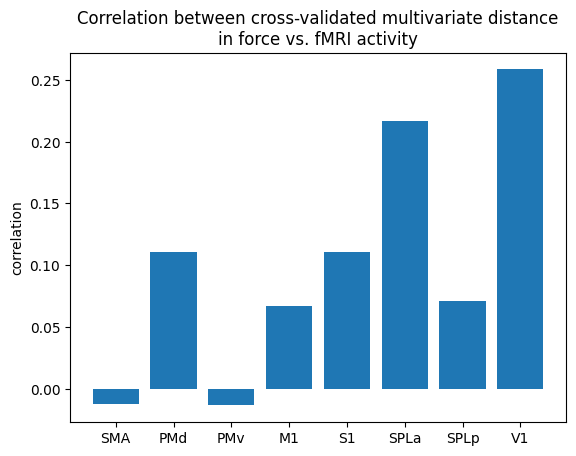

In [69]:
rois = ['SMA', 'PMd', 'PMv', 'M1', 'S1', 'SPLa', 'SPLp', 'V1']

experiment = 'efc4'

Hem = 'L'
r = 0
glm = 1

participant_id='subj100'

rdm_force = rsa.rdm.load_rdm(os.path.join(gl.baseDir, experiment, gl.rdmDir, 'day1', participant_id, f'force.hdf5'))
dforce = rdm_force.dissimilarities

corr = list()

for roi in rois:
        rdm_roi = rsa.rdm.load_rdm(os.path.join(gl.baseDir, experiment, gl.rdmDir, 'day1',participant_id,f'glm{glm}.{Hem}.{roi}.hdf5'))
        droi = rdm_roi.dissimilarities
        
        corr.append(np.corrcoef(droi, dforce)[0, 1])
        
corr = np.array(corr)

fig, axs = plt.subplots()

axs.bar(rois, corr)
axs.set_ylabel('correlation')

axs.set_title('Correlation between cross-validated multivariate distance\nin force vs. fMRI activity')

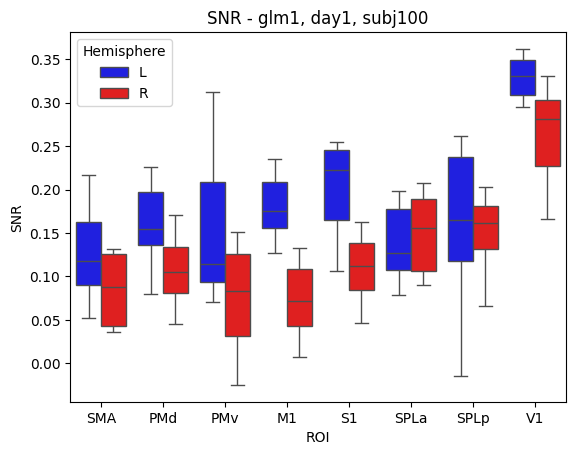

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from variance_decomposition import within_subj_var
from Functional_Fusion.dataset import reliability_within_subj

# Define parameters
experiment = 'efc4'
glm = 1
sn = 100
day = 1

# Storage for SNR values
snr_dict = {
    'ROI': [],
    'Hemisphere': [],
    'SNR': []
}

# Iterate through hemispheres and ROIs
for Hem in ['L', 'R']:
    for roi in gl.rois['ROI']:
        # Load data
        Y = np.load(os.path.join(gl.baseDir, experiment, f'{gl.glmDir}{glm}', f'day{day}', f'subj{sn}', f'ROI.{Hem}.{roi}.beta.npy'))
        res = np.load(os.path.join(gl.baseDir, experiment, f'{gl.glmDir}{glm}', f'day{day}', f'subj{sn}', f'ROI.{Hem}.{roi}.res.npy'))

        # Prewhitening
        Y = Y / np.sqrt(res)
        
        Y = Y.reshape(1, Y.shape[0], Y.shape[1])

        # Load partitioning and condition information
        reginfo = pd.read_csv(os.path.join(gl.baseDir, experiment, f'{gl.glmDir}{glm}', f'day{day}', f'subj{sn}', 'reginfo.tsv'), sep='\t')
        part_vec = reginfo.run
        cond_vec = reginfo.name

        # # Compute variance components
        # v_s, v_se = within_subj_var(Y, partition_vec, cond_vec, subtract_mean=True)
        # snr = v_s / v_se
        
        snr = reliability_within_subj(Y, part_vec, cond_vec,
                                              voxel_wise=False,
                                              subtract_mean=True)
        # snr_avg = snr.mean()
        # snr_err = snr.std()

        # Append to data list
        for s in snr[0]:
            snr_dict['ROI'].append(roi)
            snr_dict['Hemisphere'].append(Hem)
            snr_dict['SNR'].append(s)

# Convert to DataFrame
snr_df = pd.DataFrame(snr_dict)

# Pivot Data for Faceted Plot
fig, axs = plt.subplots()
sns.boxplot(data=snr_df, y='SNR', x='ROI', hue='Hemisphere', palette={'L': 'blue', 'R': 'red'}, dodge=True, ax=axs, showfliers=False)

axs.axhline(y=0, color='k', lw=.8)

# Formatting
# axs.set_xlabel("region")
axs.set_ylabel("SNR")
axs.set_title(f'SNR - glm{glm}, day{day}, subj{sn}')
axs.legend(title="Hemisphere")
plt.show()
